<h1><center> || March Madness Notebook || </center></h1>

## Importing the necessary libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.utils import shuffle

%matplotlib inline
sns.set_style('darkgrid')

## Poking around to see what we have

In [17]:
sample_sub = pd.read_csv('../Datasets/SampleSubmissionStage1.csv')
sample_sub.head(3)

,ID,Pred
0,2014_1107_1110,0.5
1,2014_1107_1112,0.5
2,2014_1107_1113,0.5


So in 2014, team 1107 has 50% chance of beating 1110

In [18]:
teams = pd.read_csv('../Datasets/DataFiles/Teams.csv')
teams.head(5)

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2018
1,1102,Air Force,1985,2018
2,1103,Akron,1985,2018
3,1104,Alabama,1985,2018
4,1105,Alabama A&M,2000,2018


In [19]:
slots = pd.read_csv('Stage2UpdatedDataFiles/NCAATourneySlots.csv')
slots.head(3)

,Season,Slot,StrongSeed,WeakSeed
0,1985,R1W1,W01,W16
1,1985,R1W2,W02,W15
2,1985,R1W3,W03,W14


Ok, think I want to know what direction I want to take this in.

In [20]:
detailed = pd.read_csv('Stage2UpdatedDataFiles/RegularSeasonDetailedResults.csv')
detailed.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23


In [21]:
detailed.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

All of the columns with 'W' correspond to the winning team's stat in that category and likewise for all columns with 'L' and the losing team.

- WFGM - field goals made (by the winning team)
- WFGA - field goals attempted (by the winning team)
- WFGM3 - three pointers made (by the winning team)
- WFGA3 - three pointers attempted (by the winning team)
- WFTM - free throws made (by the winning team)
- WFTA - free throws attempted (by the winning team)
- WOR - offensive rebounds (pulled by the winning team)
- WDR - defensive rebounds (pulled by the winning team)
- WAst - assists (by the winning team)
- WTO - turnovers committed (by the winning team)
- WStl - steals (accomplished by the winning team)
- WBlk - blocks (accomplished by the winning team)
- WPF - personal fouls committed (by the winning team)

Ultimately I'm actually going to drop all the seasons from before 2006. 2006 was when the "one-and-done" rule was implemented and the game changed significantly after.

Plus some of the biggest upsets in tournament history have been in 2006 - current, so there may be something to learn from those seasons.

#### Strategy pivot: Going to be digging only into this season's stats since I believe that the turnover rate is high enough in NCAA basketball that each season now is basically an independent event.

In [22]:
detailed = detailed.loc[detailed.Season == 2018, :]
detailed.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
76636,2018,11,1104,82,1272,70,N,0,26,57,...,17,22,36,19,24,7,17,7,3,22
76637,2018,11,1107,69,1233,67,H,0,24,62,...,22,11,14,7,20,14,7,6,3,21
76638,2018,11,1112,101,1319,67,H,0,34,57,...,13,17,30,12,11,11,13,3,1,24
76639,2018,11,1113,94,1226,74,H,0,34,65,...,24,13,22,8,21,17,14,6,2,20
76640,2018,11,1116,95,1359,56,H,0,36,63,...,29,8,15,15,17,12,19,6,1,20


#### Cool. So I learned from the Ames project that intelligent feature engineering is a HUGE part of model success.
 With that in mind, I'm not going to try to reinvent the wheel or anything, I want to incorporate a couple of the advanced
 team analytics that are currently being used in the game today.

# // Feature engineering //

References for these available below.
- Quick overview:
    - https://stats.nba.com/help/faq/
- Deeper dive:
    - http://hangtime.blogs.nba.com/2013/02/15/the-new-nba-comstats-advanced-stats-all-start-with-pace-and-efficiency/
- Actual glossary + formulas:
    - https://stats.nba.com/help/glossary/

### Starting with some building block efficiencies and possession stats

**Basic Possession Formula:**
- 0.96 x (( Field Goal Attempts ) + ( Turnovers ) + ( 0.44 x Free Throw Attempts ) - ( Offensive Rebounds )) 

In [23]:
detailed['WPos'] = detailed.apply(lambda row: 0.96*(row.WFGA + row.WTO + (0.44*row.WFTA) - row.WOR), axis=1)
detailed['LPos'] = detailed.apply(lambda row: 0.96*(row.LFGA + row.LTO + (0.44*row.LFTA) - row.LOR), axis=1)

**Offensive Efficiency Rating:**
- 100 x ( Points / Possessions )

In [24]:
detailed['WOffRtg'] = detailed.apply(lambda row: 100 * (row.WScore / row.WPos), axis=1)
detailed['LOffRtg'] = detailed.apply(lambda row: 100 * (row.LScore / row.LPos), axis=1)

**Defensive Efficiency Rating:**
- 100 x ( Opponent Points / Opponent Possessions )

In [25]:
detailed['WDefRtg'] = detailed.LOffRtg
detailed['LDefRtg'] = detailed.WOffRtg

 ### **"Four Factors"** are the box score derived metrics that correlate most closely with winning basketball games. 

**1. Shooting the Ball**
- Effective Field Goal Percentage = ( Field Goals Made + ( 0.5 x 3P Field Goals Made )) / ( Field Goal Attempts )

In [26]:
detailed['WEffFG'] = detailed.apply(lambda row: (row.WFGM + (0.5 * row.WFGM3)) / row.WFGA, axis=1)
detailed['LEffFG'] = detailed.apply(lambda row: (row.LFGM + (0.5 * row.LFGM3)) / row.LFGA, axis=1)

**2. Taking Care of the Ball**
- Turnover Rate = Turnovers / ( Field Goal Attempts + ( 0.44 x Free Throw Attempts ) + Turnovers )

In [27]:
detailed['WTOR'] = detailed.apply(lambda row: row.WTO / (row.WFGA + (0.44 * row.WFTA) + row.WTO), axis=1)
detailed['LTOR'] = detailed.apply(lambda row: row.LTO / (row.LFGA + (0.44 * row.LFTA) + row.LTO), axis=1)

In [28]:
# Checking to see that intuition should still hold up
detailed.WTOR.mean() < detailed.LTOR.mean()

True

**3. Offensive Rebounding**
- Offensive Rebounding Percentage = ( Offensive Rebounds ) / ( ( Offensive Rebounds ) + ( Opponent’s Defensive Rebounds ) )

In [29]:
detailed['WORP'] = detailed.apply(lambda row: row.WOR / (row.WOR + row.LDR), axis=1)
detailed['LORP'] = detailed.apply(lambda row: row.LOR / (row.LOR + row.WDR), axis=1)

**4. Getting to the Foul Line**
- Free Throw Rate = ( Free Throws Made ) / ( Field Goals Attempted )

In [30]:
detailed['WFTR'] = detailed.apply(lambda row: row.WFTM / row.WFGA, axis=1)
detailed['LFTR'] = detailed.apply(lambda row: row.LFTM / row.LFGA, axis=1)

In [31]:
detailed.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,WDefRtg,LDefRtg,WEffFG,LEffFG,WTOR,LTOR,WORP,LORP,WFTR,LFTR
76636,2018,11,1104,82,1272,70,N,0,26,57,...,98.749549,118.109329,0.552632,0.400000,0.187529,0.183111,0.351351,0.413043,0.333333,0.366667
76637,2018,11,1107,69,1233,67,H,0,24,62,...,107.108144,111.676507,0.419355,0.474576,0.155950,0.097007,0.487179,0.200000,0.274194,0.186441
76638,2018,11,1112,101,1319,67,H,0,34,57,...,96.664358,150.126046,0.640351,0.431034,0.134016,0.154394,0.521739,0.279070,0.491228,0.293103


### Save room for PIE

What is **PIE**?

It is a simple metric that gives an excellent indication of performance at both the team and player level. It’s a major improvement to our EFF Rating. Notably 2 things changed: 
- (1) We included Personal Fouls, 
- (2) We added a denominator. 

We feel the key here is the denominator because it acts as an "automatic equalizer". Using the denominator, we find there is no need to consider the "PACE" of the statistics that are being analyzed. In its simplest terms, PIE shows what % of game events did that player or team achieve. The stats being analyzed are your traditional basketball statistics (PTS, REB, AST, TOV, etc..) _**A team that achieves more than 50% is likely to be a winning team.**_ In fact, a team’s PIE rating and a team’s winning percentage correlate at an R square of .908 which indicates a "strong" correlation.

( PTS + FGM + FTM - FGA - FTA + DREB + ( .5 x OREB ) + AST + STL + ( .5 x BLK ) - PF - TO ) 

**__DIVIDED BY__**

( GmPTS + GmFGM + GmFTM - GmFGA - GmFTA + GmDREB + ( .5 x GmOREB ) + GmAST + GmSTL + ( .5 x GmBLK ) - GmPF - GmTO )

In [32]:
detailed['WPIE'] = detailed.apply(lambda row: \
                                            (row.WScore + row.WFGM + row.WFTM - row.WFGA - row.WFTA + row.WDR + \
                                             (.5 * row.WOR) + row.WAst + row.WStl + (.5 * row.WBlk) - row.WPF - \
                                            row.WTO) \
                                            / \
                                            ((row.WScore + row.LScore) + (row.WFGM + row.LFGM) + (row.WFTM + row.LFTM)\
                                             - (row.WFGA + row.LFGA) - (row.WFTA + row.LFTA) + (row.WDR + row.LDR)\
                                             + (.5 * (row.WOR + row.LOR)) + (row.WAst + row.LAst) + (row.WStl + row.LStl)\
                                             + (.5 * (row.WBlk + row.LBlk)) - (row.WPF + row.LPF) - (row.WTO + row.LTO))\
                                            , axis=1)

In [33]:
detailed.WPIE.mean()

0.6329131306655542

In [34]:
detailed['LPIE'] = detailed.apply(lambda row: \
                                            (row.LScore + row.LFGM + row.LFTM - row.LFGA - row.LFTA + row.LDR + \
                                             (.5 * row.LOR) + row.LAst + row.LStl + (.5 * row.LBlk) - row.LPF - \
                                            row.LTO) \
                                            / \
                                            ((row.WScore + row.LScore) + (row.WFGM + row.LFGM) + (row.WFTM + row.LFTM)\
                                             - (row.WFGA + row.LFGA) - (row.WFTA + row.LFTA) + (row.WDR + row.LDR)\
                                             + (.5 * (row.WOR + row.LOR)) + (row.WAst + row.LAst) + (row.WStl + row.LStl)\
                                             + (.5 * (row.WBlk + row.LBlk)) - (row.WPF + row.LPF) - (row.WTO + row.LTO))\
                                            , axis=1)

In [35]:
detailed.LPIE.mean()

0.36708686933444373

In [36]:
detailed.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,WEffFG,LEffFG,WTOR,LTOR,WORP,LORP,WFTR,LFTR,WPIE,LPIE
76636,2018,11,1104,82,1272,70,N,0,26,57,...,0.552632,0.400000,0.187529,0.183111,0.351351,0.413043,0.333333,0.366667,0.662791,0.337209
76637,2018,11,1107,69,1233,67,H,0,24,62,...,0.419355,0.474576,0.155950,0.097007,0.487179,0.200000,0.274194,0.186441,0.481081,0.518919
76638,2018,11,1112,101,1319,67,H,0,34,57,...,0.640351,0.431034,0.134016,0.154394,0.521739,0.279070,0.491228,0.293103,0.887967,0.112033


In [37]:
advanced_analytics = ['WPos',    'LPos',
                      'WOffRtg', 'LOffRtg',
                      'WDefRtg', 'LDefRtg',
                      'WEffFG',  'LEffFG',
                      'WTOR',    'LTOR',
                      'WORP',    'LORP',
                      'WFTR',    'LFTR',
                      'WPIE',    'LPIE']

**Don't forget to come up with a consistency rating if you have time!!**

_ Also put in some VIZZZZ here to show the advanced stats that we've got now _

## Now manipulating the structure of our data so we can have something to train the model on

In [38]:
games = []
for row in detailed.to_dict('records'):
    
    game = {}
    game['Season']      = row['Season']
    game['TeamID']      = row['WTeamID']
    game['OpponentID']  = row['LTeamID']
    game['Pos']         = row['WPos']
    game['Off_Rtg']     = row['WOffRtg']
    game['Def_Rtg']     = row['WDefRtg']
    game['Eff_FG']      = row['WEffFG']
    game['TOR']         = row['WTOR']
    game['ORP']         = row['WORP']
    game['FTR']         = row['WFTR']
    game['PIE']         = row['WPIE']
    game['Won']         = 1
    
    game['Pos_dif']     = row['WPos'] - row['LPos']
    game['Off_Rtg_dif'] = row['WOffRtg'] - row['LOffRtg']
    game['Def_Rtg_dif'] = row['WDefRtg'] - row['LDefRtg']
    game['Eff_FG_dif']  = row['WEffFG'] - row['LEffFG']
    game['TOR_dif']     = row['WTOR'] - row['LTOR']
    game['ORP_dif']     = row['WORP'] - row['LORP']
    game['FTR_dif']     = row['WFTR'] - row['LFTR']
    game['PIE_dif']     = row['WPIE'] - row['LPIE']
    
    games.append(game)
    
    # Break
    
    game = {}
    game['Season']      = row['Season']
    game['TeamID']      = row['LTeamID']
    game['OpponentID']  = row['WTeamID']
    game['Pos']         = row['LPos']
    game['Off_Rtg']     = row['LOffRtg']
    game['Def_Rtg']     = row['LDefRtg']
    game['Eff_FG']      = row['LEffFG']
    game['TOR']         = row['LTOR']
    game['ORP']         = row['LORP']
    game['FTR']         = row['LFTR']
    game['PIE']         = row['LPIE']
    game['Won']         = 0
    
    game['Pos_dif']     = row['LPos'] - row['WPos']
    game['Off_Rtg_dif'] = row['LOffRtg'] - row['WOffRtg']
    game['Def_Rtg_dif'] = row['LDefRtg'] - row['WDefRtg']
    game['Eff_FG_dif']  = row['LEffFG'] - row['WEffFG']
    game['TOR_dif']     = row['LTOR'] - row['WTOR']
    game['ORP_dif']     = row['LORP'] - row['WORP']
    game['FTR_dif']     = row['LFTR'] - row['WFTR']
    game['PIE_dif']     = row['LPIE'] - row['WPIE']
    
    games.append(game)

games_df = pd.DataFrame(games)
games_df.head(4)

,Def_Rtg,Def_Rtg_dif,Eff_FG,Eff_FG_dif,FTR,FTR_dif,ORP,ORP_dif,Off_Rtg,Off_Rtg_dif,OpponentID,PIE,PIE_dif,Pos,Pos_dif,Season,TOR,TOR_dif,TeamID,Won
0,98.749549,-19.359780,0.552632,0.152632,0.333333,-0.033333,0.351351,-0.061692,118.109329,19.359780,1272,0.662791,0.325581,69.4272,-1.4592,2018,0.187529,0.004419,1104,1
1,118.109329,19.359780,0.400000,-0.152632,0.366667,0.033333,0.413043,0.061692,98.749549,-19.359780,1104,0.337209,-0.325581,70.8864,1.4592,2018,0.183111,-0.004419,1272,0
2,107.108144,-4.568363,0.419355,-0.055221,0.274194,0.087753,0.487179,0.287179,111.676507,4.568363,1233,0.481081,-0.037838,61.7856,-0.7680,2018,0.155950,0.058943,1107,1
3,111.676507,4.568363,0.474576,0.055221,0.186441,-0.087753,0.200000,-0.287179,107.108144,-4.568363,1107,0.518919,0.037838,62.5536,0.7680,2018,0.097007,-0.058943,1233,0


In [39]:
# Just doing a quick check to make sure that we have everything duplicated aka from both perspectives.
games_df.shape[0] == (2 * detailed.shape[0])

True

In [40]:
games_df.corr().loc['Won', :].sort_values(ascending = False)

Won            1.000000
Off_Rtg_dif    0.802438
PIE_dif        0.789605
PIE            0.789605
Eff_FG_dif     0.677166
Off_Rtg        0.581066
Eff_FG         0.492607
FTR_dif        0.409038
FTR            0.278763
ORP_dif        0.229220
ORP            0.162071
TeamID         0.058640
Pos           -0.024311
OpponentID    -0.058640
TOR           -0.145443
Pos_dif       -0.163480
TOR_dif       -0.212207
Def_Rtg       -0.581066
Def_Rtg_dif   -0.802438
Season              NaN
Name: Won, dtype: float64

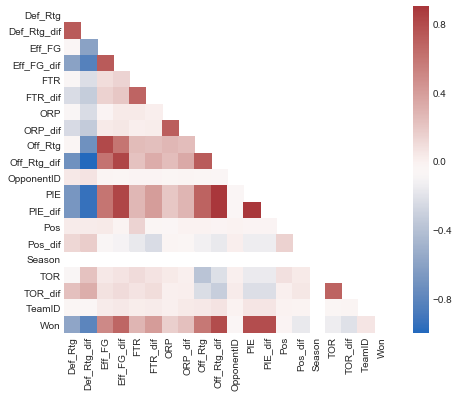

In [41]:
plt.figure(figsize=(8,6))

corr = games_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.9, square=True, cmap='vlag')

In [42]:
# SO. Now I want to get the season long averages and average differentials for each team. Then join those back into these regular season match-ups then
# train the model on those.

In [43]:
summary_stats = games_df.groupby('TeamID').mean()
summary_stats = summary_stats.add_suffix('_avg')
summary_stats.drop(['OpponentID_avg', 'Season_avg', 'Won_avg'], axis=1, inplace=True)
summary_stats.reset_index(level=0, inplace=True)
summary_stats.head(3)

,TeamID,Def_Rtg_avg,Def_Rtg_dif_avg,Eff_FG_avg,Eff_FG_dif_avg,FTR_avg,FTR_dif_avg,ORP_avg,ORP_dif_avg,Off_Rtg_avg,Off_Rtg_dif_avg,PIE_avg,PIE_dif_avg,Pos_avg,Pos_dif_avg,TOR_avg,TOR_dif_avg
0,1101,108.369964,3.027014,0.510697,-0.008713,0.240944,-0.074223,0.262368,-0.031703,105.342950,-3.027014,0.471247,-0.057506,67.262578,-0.098133,0.181402,-0.011258
1,1102,112.635920,9.150306,0.474561,-0.077822,0.242446,0.001532,0.271192,-0.014643,103.485615,-9.150306,0.444632,-0.110735,64.247172,-0.286014,0.165710,-0.018128
2,1103,114.718531,7.404159,0.515700,-0.025224,0.223778,-0.062406,0.271276,-0.011190,107.314372,-7.404159,0.436364,-0.127272,66.445626,0.068129,0.174633,0.009458


In [44]:
summary_stats

,TeamID,Def_Rtg_avg,Def_Rtg_dif_avg,Eff_FG_avg,Eff_FG_dif_avg,FTR_avg,FTR_dif_avg,ORP_avg,ORP_dif_avg,Off_Rtg_avg,Off_Rtg_dif_avg,PIE_avg,PIE_dif_avg,Pos_avg,Pos_dif_avg,TOR_avg,TOR_dif_avg
0,1101,108.369964,3.027014,0.510697,-0.008713,0.240944,-0.074223,0.262368,-0.031703,105.342950,-3.027014,0.471247,-0.057506,67.262578,-0.098133,0.181402,-0.011258
1,1102,112.635920,9.150306,0.474561,-0.077822,0.242446,0.001532,0.271192,-0.014643,103.485615,-9.150306,0.444632,-0.110735,64.247172,-0.286014,0.165710,-0.018128
2,1103,114.718531,7.404159,0.515700,-0.025224,0.223778,-0.062406,0.271276,-0.011190,107.314372,-7.404159,0.436364,-0.127272,66.445626,0.068129,0.174633,0.009458
3,1104,104.855974,-3.584883,0.517057,0.038624,0.283183,0.027988,0.289189,-0.010878,108.440857,3.584883,0.540993,0.081986,66.616094,-0.231529,0.177635,0.015054
4,1105,117.976032,24.967710,0.452615,-0.088490,0.210930,0.002441,0.298554,-0.024003,93.008322,-24.967710,0.332649,-0.334703,65.327071,0.463277,0.208856,0.064856
5,1106,116.803971,14.355957,0.463693,-0.059097,0.236357,-0.096703,0.315058,-0.032230,102.448013,-14.355957,0.406564,-0.186873,67.066219,-0.190761,0.171165,0.013756
6,1107,106.377536,-8.670888,0.506044,-0.002012,0.284933,0.090365,0.343359,0.101338,115.048423,8.670888,0.543584,0.087168,63.634994,-0.220490,0.150746,-0.001901
7,1108,115.841305,14.301455,0.486085,-0.033952,0.247896,-0.039774,0.277668,-0.052867,101.539850,-14.301455,0.415795,-0.168409,66.441600,0.171429,0.185281,0.030785
8,1110,114.979846,12.940192,0.507147,-0.044748,0.205923,-0.089531,0.236221,-0.076061,102.039654,-12.940192,0.397139,-0.205722,64.065280,-0.190720,0.184449,0.003121
9,1111,110.518245,2.501268,0.500749,-0.013624,0.247665,-0.021253,0.287093,0.029559,108.016977,-2.501268,0.467858,-0.064284,68.479587,-0.204387,0.162744,0.009272


In [45]:
pd.merge(games_df, summary_stats, on='TeamID').shape

(10810, 36)

### Bringing those season-long summary stats back into the main dataframe.

In [46]:
df = pd.merge(games_df, summary_stats, on='TeamID')

In [47]:
df = pd.merge(df, summary_stats, left_on='OpponentID', right_on='TeamID')

In [48]:
df.isnull().sum()

Def_Rtg              0
Def_Rtg_dif          0
Eff_FG               0
Eff_FG_dif           0
FTR                  0
FTR_dif              0
ORP                  0
ORP_dif              0
Off_Rtg              0
Off_Rtg_dif          0
OpponentID           0
PIE                  0
PIE_dif              0
Pos                  0
Pos_dif              0
Season               0
TOR                  0
TOR_dif              0
TeamID_x             0
Won                  0
Def_Rtg_avg_x        0
Def_Rtg_dif_avg_x    0
Eff_FG_avg_x         0
Eff_FG_dif_avg_x     0
FTR_avg_x            0
FTR_dif_avg_x        0
ORP_avg_x            0
ORP_dif_avg_x        0
Off_Rtg_avg_x        0
Off_Rtg_dif_avg_x    0
PIE_avg_x            0
PIE_dif_avg_x        0
Pos_avg_x            0
Pos_dif_avg_x        0
TOR_avg_x            0
TOR_dif_avg_x        0
TeamID_y             0
Def_Rtg_avg_y        0
Def_Rtg_dif_avg_y    0
Eff_FG_avg_y         0
Eff_FG_dif_avg_y     0
FTR_avg_y            0
FTR_dif_avg_y        0
ORP_avg_y  

### Setting up and running the model

In [49]:
train = df.loc[games_df['Season'] >= 2018, :]

In [50]:
train.columns

Index(['Def_Rtg', 'Def_Rtg_dif', 'Eff_FG', 'Eff_FG_dif', 'FTR', 'FTR_dif',
       'ORP', 'ORP_dif', 'Off_Rtg', 'Off_Rtg_dif', 'OpponentID', 'PIE',
       'PIE_dif', 'Pos', 'Pos_dif', 'Season', 'TOR', 'TOR_dif', 'TeamID_x',
       'Won', 'Def_Rtg_avg_x', 'Def_Rtg_dif_avg_x', 'Eff_FG_avg_x',
       'Eff_FG_dif_avg_x', 'FTR_avg_x', 'FTR_dif_avg_x', 'ORP_avg_x',
       'ORP_dif_avg_x', 'Off_Rtg_avg_x', 'Off_Rtg_dif_avg_x', 'PIE_avg_x',
       'PIE_dif_avg_x', 'Pos_avg_x', 'Pos_dif_avg_x', 'TOR_avg_x',
       'TOR_dif_avg_x', 'TeamID_y', 'Def_Rtg_avg_y', 'Def_Rtg_dif_avg_y',
       'Eff_FG_avg_y', 'Eff_FG_dif_avg_y', 'FTR_avg_y', 'FTR_dif_avg_y',
       'ORP_avg_y', 'ORP_dif_avg_y', 'Off_Rtg_avg_y', 'Off_Rtg_dif_avg_y',
       'PIE_avg_y', 'PIE_dif_avg_y', 'Pos_avg_y', 'Pos_dif_avg_y', 'TOR_avg_y',
       'TOR_dif_avg_y'],
      dtype='object')

In [51]:
train.shape

(10810, 53)

In [52]:
new_features = [col for col in train.columns if col not in ['TeamID', 'OpponentID', 'Won', 'TeamID_x', 'TeamID_y', 'Season']]

In [53]:
new_features = [x for x in new_features if 'avg' in str(x)]

In [54]:
X = train[new_features]
y = train['Won']

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 23)

In [56]:
rf = RandomForestClassifier(random_state=44)

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Method of selecting samples for training each tree
bootstrap = [True, False]

rf_params = {
    'n_estimators': n_estimators,
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_depth': max_depth,
    'max_features': ['auto', 'log2'],
    'bootstrap': bootstrap
}
rs_rf = RandomizedSearchCV(rf, rf_params)
rs_rf.fit(X_train, y_train)
print (rs_rf.best_score_)
rs_rf.best_params_

0.708646848402615


{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 600}

In [57]:
rs_rf.score(X_val, y_val)

0.6914539400665927

OG Best Params

'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 200

In [88]:
rs_rf = RandomForestClassifier(random_state=44, bootstrap=True, criterion='gini', max_depth=None, max_features='log2', min_samples_leaf=4, min_samples_split=10, n_estimators=200)
rs_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=44, verbose=0, warm_start=False)

In [89]:
rs_rf.score(X_val, y_val)

0.6833148353681096

### Building out the predictions for the actual tournament!

In [90]:
sample_sub2 = pd.read_csv('Stage2UpdatedDataFiles/SampleSubmissionStage2.csv')
sample_sub2.shape

(2278, 2)

In [91]:
# Starting to build out my "true test" to make predictions

test = pd.read_csv('Stage2UpdatedDataFiles/SampleSubmissionStage2.csv')
display(test.head())
print(test.shape)

,ID,Pred
0,2018_1104_1112,0.5
1,2018_1104_1113,0.5
2,2018_1104_1116,0.5
3,2018_1104_1120,0.5
4,2018_1104_1137,0.5


(2278, 2)


In [92]:
test['Season']     = test['ID'].apply(lambda ID: int(ID.split('_')[0]))
test['TeamID']     = test['ID'].apply(lambda ID: int(ID.split('_')[1]))
test['OpponentID'] = test['ID'].apply(lambda ID: int(ID.split('_')[2]))

test.head(3)

,ID,Pred,Season,TeamID,OpponentID
0,2018_1104_1112,0.5,2018,1104,1112
1,2018_1104_1113,0.5,2018,1104,1113
2,2018_1104_1116,0.5,2018,1104,1116


In [93]:
potential_games = []
for row in test.to_dict('records'):
    
    game = {}
    game['Season']     = row['Season']
    game['TeamID']     = row['TeamID']
    game['OpponentID'] = row['OpponentID']
    
    potential_games.append(game)
    
    # Break
    
    game = {}
    game['Season']     = row['Season']
    game['TeamID']     = row['OpponentID']
    game['OpponentID'] = row['TeamID']
    
    potential_games.append(game)

tourney = pd.DataFrame(potential_games)
tourney.head(4)

,OpponentID,Season,TeamID
0,1112,2018,1104
1,1104,2018,1112
2,1113,2018,1104
3,1104,2018,1113


In [94]:
# Checking to make sure that worked...
tourney.shape[0] / sample_sub2.shape[0] == 2

True

In [95]:
tourney.shape

(4556, 3)

In [96]:
tourney = pd.merge(tourney, summary_stats, on='TeamID')

In [97]:
tourney.columns

Index(['OpponentID', 'Season', 'TeamID', 'Def_Rtg_avg', 'Def_Rtg_dif_avg',
       'Eff_FG_avg', 'Eff_FG_dif_avg', 'FTR_avg', 'FTR_dif_avg', 'ORP_avg',
       'ORP_dif_avg', 'Off_Rtg_avg', 'Off_Rtg_dif_avg', 'PIE_avg',
       'PIE_dif_avg', 'Pos_avg', 'Pos_dif_avg', 'TOR_avg', 'TOR_dif_avg'],
      dtype='object')

In [98]:
tourney = pd.merge(tourney, summary_stats, left_on='OpponentID', right_on='TeamID')

In [99]:
tourney.columns

Index(['OpponentID', 'Season', 'TeamID_x', 'Def_Rtg_avg_x',
       'Def_Rtg_dif_avg_x', 'Eff_FG_avg_x', 'Eff_FG_dif_avg_x', 'FTR_avg_x',
       'FTR_dif_avg_x', 'ORP_avg_x', 'ORP_dif_avg_x', 'Off_Rtg_avg_x',
       'Off_Rtg_dif_avg_x', 'PIE_avg_x', 'PIE_dif_avg_x', 'Pos_avg_x',
       'Pos_dif_avg_x', 'TOR_avg_x', 'TOR_dif_avg_x', 'TeamID_y',
       'Def_Rtg_avg_y', 'Def_Rtg_dif_avg_y', 'Eff_FG_avg_y',
       'Eff_FG_dif_avg_y', 'FTR_avg_y', 'FTR_dif_avg_y', 'ORP_avg_y',
       'ORP_dif_avg_y', 'Off_Rtg_avg_y', 'Off_Rtg_dif_avg_y', 'PIE_avg_y',
       'PIE_dif_avg_y', 'Pos_avg_y', 'Pos_dif_avg_y', 'TOR_avg_y',
       'TOR_dif_avg_y'],
      dtype='object')

In [100]:
predictions = rs_rf.predict_proba(tourney[new_features])[:, 1]

In [101]:
len(predictions)

4556

In [102]:
tourney['Pred'] = predictions

In [103]:
tourney.head()

,OpponentID,Season,TeamID_x,Def_Rtg_avg_x,Def_Rtg_dif_avg_x,Eff_FG_avg_x,Eff_FG_dif_avg_x,FTR_avg_x,FTR_dif_avg_x,ORP_avg_x,...,ORP_dif_avg_y,Off_Rtg_avg_y,Off_Rtg_dif_avg_y,PIE_avg_y,PIE_dif_avg_y,Pos_avg_y,Pos_dif_avg_y,TOR_avg_y,TOR_dif_avg_y,Pred
0,1112,2018,1104,104.855974,-3.584883,0.517057,0.038624,0.283183,0.027988,0.289189,...,0.084087,122.505612,15.718304,0.617239,0.234477,65.991529,-0.548894,0.156565,0.0076,0.080061
1,1112,2018,1113,108.396941,-12.139042,0.540991,0.030367,0.318393,0.075764,0.281520,...,0.084087,122.505612,15.718304,0.617239,0.234477,65.991529,-0.548894,0.156565,0.0076,0.566568
2,1112,2018,1116,111.079641,-6.830480,0.540016,0.036195,0.260800,-0.042764,0.294323,...,0.084087,122.505612,15.718304,0.617239,0.234477,65.991529,-0.548894,0.156565,0.0076,0.302706
3,1112,2018,1120,105.430996,-13.866953,0.520490,0.023600,0.316554,0.033519,0.326259,...,0.084087,122.505612,15.718304,0.617239,0.234477,65.991529,-0.548894,0.156565,0.0076,0.617529
4,1112,2018,1137,104.193261,-11.915957,0.543699,0.068687,0.310584,0.067222,0.271282,...,0.084087,122.505612,15.718304,0.617239,0.234477,65.991529,-0.548894,0.156565,0.0076,0.502844


In [104]:
tourn_corr = tourney[tourney['TeamID_x'] < tourney['OpponentID']]

In [105]:
tourn_corr['ID'] = tourn_corr.apply(lambda row: '{}_{}_{}'.format(int(row['Season']), int(row['TeamID_x']), int(row['OpponentID'])), axis = 1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [106]:
tourn_corr.head()

,OpponentID,Season,TeamID_x,Def_Rtg_avg_x,Def_Rtg_dif_avg_x,Eff_FG_avg_x,Eff_FG_dif_avg_x,FTR_avg_x,FTR_dif_avg_x,ORP_avg_x,...,Off_Rtg_avg_y,Off_Rtg_dif_avg_y,PIE_avg_y,PIE_dif_avg_y,Pos_avg_y,Pos_dif_avg_y,TOR_avg_y,TOR_dif_avg_y,Pred,ID
0,1112,2018,1104,104.855974,-3.584883,0.517057,0.038624,0.283183,0.027988,0.289189,...,122.505612,15.718304,0.617239,0.234477,65.991529,-0.548894,0.156565,0.007600,0.080061,2018_1104_1112
67,1113,2018,1104,104.855974,-3.584883,0.517057,0.038624,0.283183,0.027988,0.289189,...,120.535983,12.139042,0.569134,0.138267,69.290942,-0.423639,0.130841,-0.046328,0.597357,2018_1104_1113
68,1113,2018,1112,106.787308,-15.718304,0.569693,0.075634,0.294858,0.060403,0.329417,...,120.535983,12.139042,0.569134,0.138267,69.290942,-0.423639,0.130841,-0.046328,0.738149,2018_1112_1113
134,1116,2018,1104,104.855974,-3.584883,0.517057,0.038624,0.283183,0.027988,0.289189,...,117.910121,6.830480,0.546346,0.092693,68.606118,0.332047,0.134841,-0.034584,0.382128,2018_1104_1116
135,1116,2018,1112,106.787308,-15.718304,0.569693,0.075634,0.294858,0.060403,0.329417,...,117.910121,6.830480,0.546346,0.092693,68.606118,0.332047,0.134841,-0.034584,0.652082,2018_1112_1116


In [107]:
submissions = pd.DataFrame()
submissions['ID'] = tourn_corr['ID']
submissions['Pred'] = tourn_corr['Pred']

submissions.head()

,ID,Pred
0,2018_1104_1112,0.080061
67,2018_1104_1113,0.597357
68,2018_1112_1113,0.738149
134,2018_1104_1116,0.382128
135,2018_1112_1116,0.652082


In [108]:
submissions.to_csv('MM_submissions_2.csv', index=False)

In [109]:
submissions.Pred.max()

0.9420872311168363

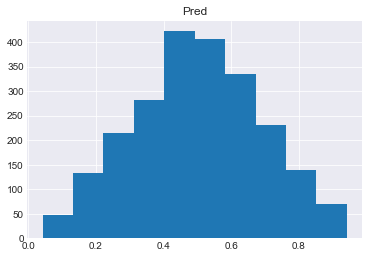

In [110]:
submissions.hist(column='Pred', bins = 10);

### Visualizing a bracket based on my predictions

In [111]:
teams.loc[teams.TeamName == 'Arizona St', :]

,TeamID,TeamName,FirstD1Season,LastD1Season
12,1113,Arizona St,1985,2018


In [112]:
teams.loc[teams.TeamName == 'Syracuse', :]

,TeamID,TeamName,FirstD1Season,LastD1Season
292,1393,Syracuse,1985,2018


In [113]:
submissions.loc[submissions.ID == '2018_1113_1393', :]

,ID,Pred
3352,2018_1113_1393,0.653982


In [114]:
submissions.set_value(3352, 'Pred', 0.4999)

,ID,Pred
0,2018_1104_1112,0.080061
67,2018_1104_1113,0.597357
68,2018_1112_1113,0.738149
134,2018_1104_1116,0.382128
135,2018_1112_1116,0.652082
136,2018_1113_1116,0.587313
201,2018_1104_1120,0.461294
202,2018_1112_1120,0.476311
203,2018_1113_1120,0.596957
204,2018_1116_1120,0.445451


In [115]:
submissions.to_csv('MM_submissions_2.csv', index=False)

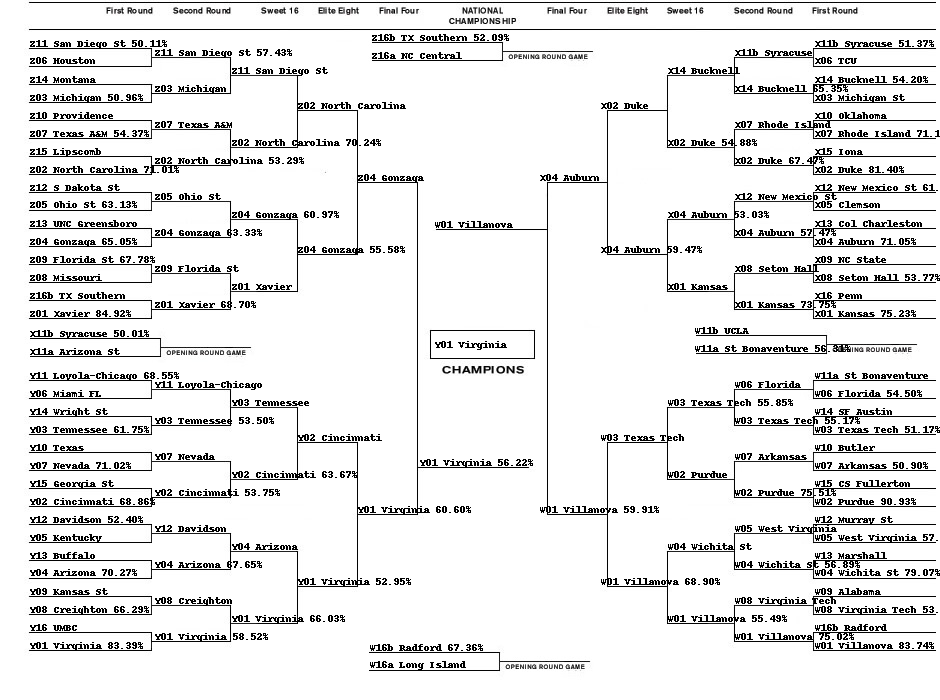

In [116]:
from bracketeer import build_bracket
b = build_bracket(
        outputPath='output.png',
        teamsPath='../Datasets/DataFiles/Teams.csv',
        seedsPath='Stage2UpdatedDataFiles/NCAATourneySeeds.csv',
        submissionPath='MM_submissions_2.csv',
        slotsPath='Stage2UpdatedDataFiles/NCAATourneySlots.csv',
        year=2018
)

from IPython.display import Image
Image("output.png")

In [120]:
rs_rf.feature_importances_

array([0.03079953, 0.05540037, 0.01994204, 0.03155341, 0.01849015,
       0.01858212, 0.01883329, 0.01940497, 0.03392523, 0.06678641,
       0.0561224 , 0.05092772, 0.01898301, 0.01814855, 0.01984896,
       0.01898022, 0.02669659, 0.06522537, 0.02218822, 0.03419866,
       0.01875569, 0.01816576, 0.01753096, 0.01890053, 0.0339886 ,
       0.05680317, 0.05393907, 0.05910929, 0.01830432, 0.01839134,
       0.02116435, 0.01990972])

In [130]:
fi = pd.DataFrame({
        'feature':train[new_features].columns,
        'importance':rs_rf.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi.iloc[0:5, :]

,feature,importance
9,Off_Rtg_dif_avg_x,0.066786
17,Def_Rtg_dif_avg_y,0.065225
27,PIE_dif_avg_y,0.059109
25,Off_Rtg_dif_avg_y,0.056803
10,PIE_avg_x,0.056122


In [137]:
interest_cols = list(fi.iloc[0:5,:]['feature'].values)

In [139]:
interest_cols

['Off_Rtg_dif_avg_x',
 'Def_Rtg_dif_avg_y',
 'PIE_dif_avg_y',
 'Off_Rtg_dif_avg_y',
 'PIE_avg_x']

In [140]:
summary_stats.columns

Index(['TeamID', 'Def_Rtg_avg', 'Def_Rtg_dif_avg', 'Eff_FG_avg',
       'Eff_FG_dif_avg', 'FTR_avg', 'FTR_dif_avg', 'ORP_avg', 'ORP_dif_avg',
       'Off_Rtg_avg', 'Off_Rtg_dif_avg', 'PIE_avg', 'PIE_dif_avg', 'Pos_avg',
       'Pos_dif_avg', 'TOR_avg', 'TOR_dif_avg'],
      dtype='object')

In [142]:
train.loc[train.TeamID_x == 1137, interest_cols] # Bucknell

,Off_Rtg_dif_avg_x,Def_Rtg_dif_avg_y,PIE_dif_avg_y,Off_Rtg_dif_avg_y,PIE_avg_x
819,11.915957,-6.830480,0.092693,6.830480,0.58443
1123,11.915957,11.605748,-0.172279,-11.605748,0.58443
1161,11.915957,11.501862,-0.167647,-11.501862,0.58443
1162,11.915957,11.501862,-0.167647,-11.501862,0.58443
1163,11.915957,11.501862,-0.167647,-11.501862,0.58443
1544,11.915957,3.088099,-0.023043,-3.088099,0.58443
1545,11.915957,3.088099,-0.023043,-3.088099,0.58443
1546,11.915957,3.088099,-0.023043,-3.088099,0.58443
1628,11.915957,7.331369,-0.071908,-7.331369,0.58443
1629,11.915957,7.331369,-0.071908,-7.331369,0.58443


In [143]:
train.loc[train.TeamID_x == 1277, interest_cols] # Michigan State

,Off_Rtg_dif_avg_x,Def_Rtg_dif_avg_y,PIE_dif_avg_y,Off_Rtg_dif_avg_y,PIE_avg_x
172,24.142286,1.320317,-0.004688,-1.320317,0.686596
1315,24.142286,7.642852,-0.083802,-7.642852,0.686596
1874,24.142286,3.887455,-0.076048,-3.887455,0.686596
2572,24.142286,-22.592086,0.312687,22.592086,0.686596
2601,24.142286,5.819346,-0.063516,-5.819346,0.686596
3386,24.142286,9.829155,-0.141706,-9.829155,0.686596
4002,24.142286,-11.694947,0.148270,11.694947,0.686596
5195,24.142286,12.332713,-0.201737,-12.332713,0.686596
5493,24.142286,-1.834665,0.019234,1.834665,0.686596
5494,24.142286,-1.834665,0.019234,1.834665,0.686596


In [124]:
summary_stats.loc[summary_stats.TeamID == 1277, :]

,TeamID,Def_Rtg_avg,Def_Rtg_dif_avg,Eff_FG_avg,Eff_FG_dif_avg,FTR_avg,FTR_dif_avg,ORP_avg,ORP_dif_avg,Off_Rtg_avg,Off_Rtg_dif_avg,PIE_avg,PIE_dif_avg,Pos_avg,Pos_dif_avg,TOR_avg,TOR_dif_avg
169,1277,99.899545,-24.142286,0.576735,0.149343,0.280398,0.063813,0.367622,0.106548,124.041831,24.142286,0.686596,0.373193,65.172945,0.046545,0.165566,0.040671


# D Time Boogie.

### The plan:

- I want to build a scraper to pull in all the team season-long average stats.
- Then put those with each regular season game so that way the model can learn from the labels (W/L).
    - This should also include location to learn who is playing better on the road / neutral.
- Also (time permitting) I want to include the mascots by weight feature to make it a little different and fun.

In [91]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from time import sleep
import re

**Getting a list of the team names and their corresponding URLs:**

In [ ]:
res = requests.get('http://stats.ncaa.org/team/inst_team_list?academic_year=2017&conf_id=-1&division=1&sport_code=MBB')
soup = BeautifulSoup(res.content, 'lxml')

In [ ]:
giant_table = soup.find('div', {'class': 'css-panes'}).find('table')

In [ ]:
team_names = []
team_urls = []

In [ ]:
for column in giant_table.find_all('table'):
    for link in column.find_all('a'):
        team_names.append(link.text)
        team_urls.append('http://stats.ncaa.org/team' + str(link.attrs.get('href')))

**Trying to get a single team's stats:**

In [159]:
res = requests.get('http://stats.ncaa.org/teams/42595')
soup = BeautifulSoup(res.content, 'lxml')
res.status_code

200

In [231]:
stat_names = []
stat_values = []

for stat_name in soup.find_all('a', {'target': 'Rankings'}):
    stat_names.append(stat_name.text)
    
for i, x in enumerate(soup.find_all('td', {'align': 'right'})):
    if i % 2 != 0:
        stat_values.append(x.text)
        stat_values = [num.replace(" ", "") for num in stat_values]
        stat_values = [num.replace('\n', '') for num in stat_values]

**Now putting it all together into a scraper that will go into each team's URL**

In [233]:
team_stats = []

# starting_url = 'http://stats.ncaa.org/team/inst_team_list?academic_year=2017&conf_id=-1&division=1&sport_code=MBB'

def scrape_team_stats(url_list):
    missed_url_list = []
    for team in url_list:
        
        stat_values = []

        soup = BeautifulSoup(requests.get(team).content, 'html.parser')

        for i, x in enumerate(soup.find_all('td', {'align': 'right'})):
            if i % 2 != 0:
                stat_values.append(x.text)
                stat_values = [num.replace(" ", "") for num in stat_values]
                stat_values = [num.replace('\n', '') for num in stat_values]

        if stat_values != []:
            stat_values.append(team)
            team_stats.append(stat_values)
        else:
            missed_url_list.append(team)
                
    if len(missed_url_list) == 0:
        return team_stats
    else:
        return scrape_team_stats(missed_url_list)
            
scrape_team_stats(team_urls)

KeyboardInterrupt: 

**Don't forget to make a "difficulty by seed" feature!!!**

Very interesting to think about the difficulty of the path to the final that way, though I would've probably tried to weigh it by the probability that your team will face that seed in the next round instead of just assuming you will face the higher seed.

i mean use bayes - instead of saying the 5 auto plays the 4 next round say they get 12*probability 5 will win + 5* probability 12 will win